# Keyphrases in Plot Summaries

## Phrase mining and filtering

(TODO : Definition of a high quality phrase)

(TODO : How this will help us understand the interaction of technology and cinema)

In [38]:
# Imports
import json
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
from helpers import print_versions, load_data_with_columns, bin_into_decades, percent_nans, expand_list_data, duplicate_singleton, plot_with_confidence

print_versions([pd, json, np, scp])

pandas==2.1.1
json==2.0.9
numpy==1.26.1
scipy==1.11.3


In [2]:
# Loading data
DATAFOLDER = '../data/'
plot_summaries = load_data_with_columns(DATAFOLDER, 'plot_summaries.txt')
movie_metadata = load_data_with_columns(DATAFOLDER, 'movie.metadata.tsv')

# Exploratory Data Analysis

In [3]:
# Display movie metadata
movie_metadata

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,box_office,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


In [4]:
# Display plot summaries
plot_summaries

,movie_wikipedia_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


## Missing or duplicate data

There appear to be more rows in movie_metadata than in plot_summaries. We diagnose the problem.

1. We check for duplicates : 
    + Are the wikipedia IDs unique in movie_metadata and plot_summaries?
        + Answer: Yes.
    + Are there duplicate summary texts?
        + Answer: Yes.
2. We check for missing data :
    + Are the wikipedia IDs in plot_summaries a subset of those in movie_metadata?
        + Answer: No, there are 99 summaries with no associated metadata.
    + What percentage of movies are missing per year?
        + Answer: Varies
3. We check data quality : 
    + Spelling mistakes?
        + Answer: 

In [5]:
# The wikipedia_id's are unique in both tables.
assert(movie_metadata['movie_wikipedia_id'].is_unique)
assert(plot_summaries['movie_wikipedia_id'].is_unique)

# Summaries with no metadata
movie_metadata_ids = movie_metadata['movie_wikipedia_id'].to_list()
plot_summaries_ids = plot_summaries['movie_wikipedia_id'].to_list()
plot_no_metadata = [id for id in plot_summaries_ids if id not in movie_metadata_ids]

In [6]:
# Number of summaries with no metadata.
print("There are {:d} plot summaries with no associated metadata".format(len(plot_no_metadata)))
plot_summaries.set_index('movie_wikipedia_id').loc[plot_no_metadata].reset_index()

There are 99 plot summaries with no associated metadata


,movie_wikipedia_id,plot
0,2862137,Sathyanarayan Murthy is a rough but kind man ...
1,33334420,{{more plot}} Mural tells the story of Zhu Xia...
2,16758721,"The story is about a young man “Tony”, a 25 ye..."
3,23217064,"Years before the events of the first film, Lo..."
4,2746943,"A young 16-year-old girl, Zhu Ying Tai, manage..."
...,...,...
94,35607003,Parisian Marion is living in New York with her...
95,32942181,"Rajat , Nishant ""Liquid"" Agarwal and Vikrant ..."
96,133671,Gerry Conlon is shown in Belfast stripping le...
97,34076714,"After a hit gone wrong, Nikita, an exiled Russ..."


In [7]:
# Duplicate plot texts
duplicated_plots = plot_summaries[plot_summaries['plot'].duplicated(keep=False)]
print("There are {:d} plot summaries that appear more than once.".format(len(duplicated_plots['plot'].unique())))

There are 5 plot summaries that appear more than once.


In [8]:
# Left-merge movie metadata with plots. This disregards the 99 plots with no metadata
movies_with_plots = movie_metadata.merge(plot_summaries, how='left')

# There are movies with different titles but identical plots.
movies_with_plots.set_index('movie_wikipedia_id').loc[duplicated_plots['movie_wikipedia_id']].groupby('plot')['movie_name'].unique().reset_index()

,plot,movie_name
0,A woman is thrown out of her home by her jealo...,"[Madame X, The Trial of Madame X]"
1,An orphan Raghav turns into a ruthless contrac...,"[Antham, Drohi]"
2,"As the American Civil War begins, Ned Burton l...",[The Warrens of Virginia]
3,Raja was adopted by a criminal don at a very ...,[Amar Deep]
4,Taking a step aside from the usual serious dra...,"[Andhamaina Anubhavam, Ninaithale Inikkum]"


What can we know about these movies whose plots appear multiple times?

In [9]:
# Print data about those movies who share a plot with another movie.
movie_metadata[movie_metadata['movie_wikipedia_id'].isin(duplicated_plots['movie_wikipedia_id'])][['movie_name', 'movie_release_date', 'languages', 'countries']].sort_values(by='movie_name')

,movie_name,movie_release_date,languages,countries
22185,Amar Deep,1979,[Hindi Language],[India]
32255,Amar Deep,NaN,[Hindi Language],[]
59148,Andhamaina Anubhavam,1979,[Telugu language],[India]
67464,Antham,1992-09-11,[Telugu language],[India]
28621,Drohi,1992-10-25,[Hindi Language],[India]
18993,Madame X,1916-01-14,"[Silent film, English Language]",[United States of America]
49381,Madame X,1920-09-26,"[Silent film, English Language]",[United States of America]
57569,Madame X,1954,[Greek Language],[Greece]
65014,Madame X,1981-03-16,[English Language],[United States of America]
59142,Ninaithale Inikkum,1979-04-14,[Tamil Language],[India]


We note the following:
1. *Andhamaina Anubhavam* / *Ninaithale Inikkum* are the Telugu and Tamil names for the same movie. 
2. *Antham* / *Drohi* are the Telugu and Hindi names for the same movie.
3. There are multiple movie adaptations of the play *(The Trial of) Madame X*. 
4. There is a "lost" 1924 version of the movie The Warrens of Virginia, with the same plot, but it appears in this dataset.
5. The movie *Amar Deep* appearing twice appears to simply be a dataset error.

What is the percentage of missing plot summary data per decade?

In [66]:
# Bin movies into decades
movies_with_decades = bin_into_decades(movies_with_plots, 'movie_release_date').copy()

# Bootstrap parameters
bootstrap_args = {'statistic' : percent_nans, 'n_resamples':10, 'confidence_level':0.95, 'alternative':'two-sided', 'method':'percentile'}

# Groupby decades
plots_by_decade = movies_with_decades.groupby('decade', observed=False, group_keys=True)['plot']

# Perform bootstrap estimation of missing plot summary data
intervals_by_decade = plots_by_decade.apply(lambda x: bootstrap((duplicate_singleton(x), ), **bootstrap_args).confidence_interval[:])

# Unpack intervals into dataframe
low_high_by_decade = expand_list_data(pd.DataFrame(intervals_by_decade).set_axis(['interval'],axis=1), 'interval', ['low', 'high']).copy()

# Put data together
missing_plots = pd.concat([pd.DataFrame({
    'mean':plots_by_decade.apply(percent_nans), 
    'count':plots_by_decade.apply(lambda x: x.isnull().sum())}), 
    low_high_by_decade], axis=1)

While the number of missing plots increases every decade, the overall percentage of missing plots goes down.

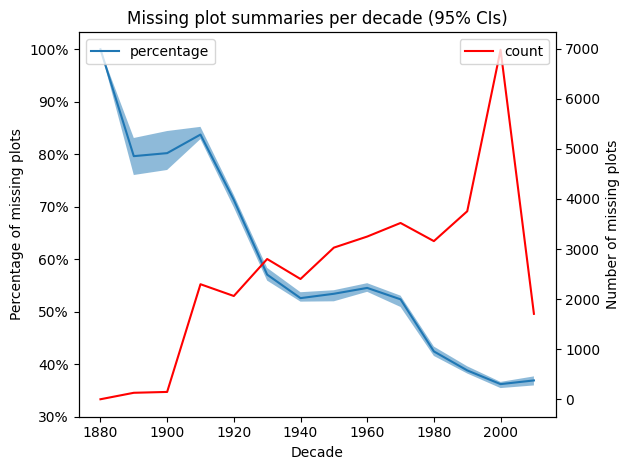

In [80]:
# Plot percentage and count
fig, ax1 = plt.subplots()
ax1.set_title(f"Missing plot summaries per decade (95% CIs)")
ax1.set_xlabel("Decade")
ax1.set_ylabel("Percentage of missing plots")
plot_with_confidence(missing_plots, 'mean', 'percentage', ax1)
ax1.set_yticks(ticks=ax1.get_yticks()[:-1], labels=["{:.0f}%".format(p*100) for p in ax1.get_yticks()[:-1]])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of missing plots')
ax2.plot(missing_plots['count'], label = 'count', color='red')
ax2.legend(loc='upper right')
ax2.tick_params(axis='y')


fig.tight_layout()
plt.show()

## Spell check

In [146]:
from autocorrect import Speller

spell = Speller(lang='en', fast=True)
spell('banishes')

'banished'